```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments

def split_segments_overlap(df, chunk_size=5, seq_len=25):
    num_of_chunk = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_chunk - chunk_size):
        seg = df.iloc[int(i * seq_len):int((i + chunk_size) * seq_len)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments

# def split_segments_overlap(df, chunk_size=5, seq_len=25):
#     total_length = chunk_size * seq_len
    
#     segments = []
#     for i in range(0, len(df) - total_length, 5):
#         seg = df.iloc[i:i + total_length].to_numpy()
#         segments.append(np.array(np.split(seg, chunk_size)))
        
#     return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25, is_train_data=False):
    pre_df = select_data(df)
    
    if is_train_data:
        segs = split_segments_overlap(pre_df, chunk_size, seq_len)
    else:
        segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    pair_data = []
    files = os.listdir(root_folder)
    if file_index is not None:
        files = files[file_index[0]:file_index[1]]

    for folder in files:
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
                
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len, is_train_data)
        target_segs = preprocess_data(target_df, chunk_size, seq_len, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [9]:
datapoint_per_second = 20
duration = 2
chunk_size = 7
seq_len = 21
classes = {0: 'target', 1: 'front_pocket', 2: 'pocket', 3: 'swing'}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
train_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[0, 8], is_train_data=True)
valid_front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1, file_index=[8, 10], is_train_data=False)

train_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[0, 8], is_train_data=True)
valid_pocket_pair_data = load_pair_data('./pocket', class_num=2, file_index=[8, 10], is_train_data=False)

train_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[0, 8], is_train_data=True)
valid_swing_pair_data = load_pair_data('./swing', class_num=3, file_index=[8, 10], is_train_data=False)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./pocket/202302132108
./pocket/202302132108/source ./pocket/202302132108/target
./pocket/202302131750
./pocket/2023021

In [12]:
print(len(train_front_pocket_pair_data), len(train_pocket_pair_data), len(train_swing_pair_data))

1880 1838 1782


In [13]:
train_front_pocket_pair_data[0][0][0, -1], train_front_pocket_pair_data[0][2][0, -1]

(array([-1.46666997e+00,  3.02090550e-02,  1.02965024e+00, -4.78252917e-01,
        -3.82730037e-01,  1.22318631e-02,  8.28334045e+00, -1.33542404e+01,
         4.17045288e+01,  1.67575811e+09]),
 array([ 1.25826234e-01, -1.58992693e+00, -1.53935553e+00, -6.28472567e-02,
         3.16822752e-02,  2.58390278e-01, -3.71943283e+01,  1.32483292e+00,
        -2.49790649e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [16]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean', chunk_size=5):
        super(FirstDerivativeLoss, self).__init__()
        self.chunk_size = chunk_size

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), self.chunk_size, -1))
        target_o = torch.reshape(target, (len(target), self.chunk_size, -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [17]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)

    total_loss = imu_loss + mag_loss #+ d1_loss
    return total_loss, imu_loss, mag_loss, d1_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [18]:
train_data = train_front_pocket_pair_data + train_pocket_pair_data + train_swing_pair_data
valid_data = valid_front_pocket_pair_data + valid_pocket_pair_data + valid_swing_pair_data

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=512)

In [19]:
batch = next(iter(train_loader))

In [20]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [31]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Linear(6, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 16),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * seq_len, hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = self.cnn(x)
#         h = torch.reshape(h, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    
    def predict_label(self, x):
        predict_probability, _ = self(x)
        predict_probability = predict_probability.reshape((-1, self.num_of_classes))
        _, predict_classes = torch.max(predict_probability, 1)
        one_hot = F.one_hot(predict_classes, num_classes=self.num_of_classes).to(device).float()
        class_result = one_hot.reshape(-1, self.chunk_size, self.num_of_classes)
        
        return class_result


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 16),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        self.mag_pos_encoder = PositionalEncoding(16 * self.seq_len, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.2, batch_first=True), num_layers=4)
        self.nn = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 6),
            nn.LeakyReLU(),
        )
        
        self.task_controller_net = nn.Sequential(
            nn.Linear(1348, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 64),
            nn.LeakyReLU(), 
            nn.Linear(64, 9),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64* self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
#         self.mag_last = nn.Sequential(
#             nn.Linear(64, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 3),
#         )

        self.mag_last = nn.Sequential(
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 3),
        )
        
    def forward(self, source_imu, source_mag, class_result):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = h_imu.reshape((len(source_imu), self.chunk_size, -1))
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = source_mag
#         h_mag = h_mag.reshape((len(source_mag), self.chunk_size, -1))
#         h_mag = self.mag_pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = z.reshape((len(source_imu), self.chunk_size, self.seq_len, -1))
        z_imu = self.nn(z_imu)
        
        z_class = torch.concat([z, class_result], dim=-1)
        task_latent = self.task_controller_net(z_class)
        
        ### step 3
#         pred_latent = self.decoder(h_mag, z)
#         pred_mag = pred_latent.reshape((len(source_mag), self.chunk_size, self.seq_len, -1))
        
#         pred_mag = pred_mag + task_latent[:, :, None, :]
#         pred_mag = self.mag_last(pred_mag)

        task_matrix = task_latent.reshape((len(source_mag), self.chunk_size, 3, 3))  # (bs, cs, 3, 3)
        #task_matrix = self.mag_last(task_matrix)
        pred_mag = torch.matmul(h_mag, task_matrix)
        
#         pred_mag = self.mag_last(pred_mag)
#         pred_mag = pred_mag + finetune_mag
        
        
        return z_imu, pred_mag
        

In [22]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [23]:
EPOCH = 2000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss(chunk_size=chunk_size)

# Train classifier

In [32]:
classifier = Classifier(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=0.00005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_C, T_max=50, eta_min=0.0000001)

In [25]:
def train_C(model, dataloader, optimizer):
    model.train()

    losses = []
    accuracies = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        sequences = torch.concat([source_data[:, :, :, :6], target_data[::3, :, :, :6]])
        labels = torch.concat([source_label, target_label[::3]])
        
        sequences = sequences.to(device)
        one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()
        one_hot = one_hot[:, None, :].repeat((1, chunk_size, 1)).float()

        #############
        # generator #
        #############
        predict_probability, _ = model(sequences)
        
        loss = ce_loss(predict_probability, one_hot)
        
        # backward
        loss.backward()
        optimizer.step()
        
        _, predict_classes = torch.max(predict_probability, 1)
        predict_classes = predict_classes.cpu().detach().numpy()
        _, labels = torch.max(one_hot, 1)
        labels = labels.cpu().detach().numpy()
        
        losses.append(loss.item())
        accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [26]:
def evalute_C(model, dataloader):
    model.eval()

    losses = []
    accuracies = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            
            sequences = torch.concat([source_data[:, :, :, :6], target_data[:, :, :, :6]])
            labels = torch.concat([source_label, target_label])
            
            sequences = sequences.to(device)
            one_hot = F.one_hot(labels, num_classes=num_of_classes).to(device).float()
            one_hot = one_hot[:, None, :].repeat((1, chunk_size, 1)).float()

            #############
            # generator #
            #############
            predict_probability, _ = model(sequences[:, :, :, :9])
            
            loss = ce_loss(predict_probability, one_hot)

            _, predict_classes = torch.max(predict_probability, 1)
            predict_classes = predict_classes.cpu().detach().numpy()
            _, labels = torch.max(one_hot, 1)
            labels = labels.cpu().detach().numpy()
            
            losses.append(loss.item())
            accuracies.append(accuracy_score(labels, predict_classes))
    
    return np.mean(losses), np.mean(accuracies)

In [33]:
for epoch in range(500):
    train_loss, train_acc = train_C(classifier, train_loader, optimizer_C)
    lr_scheduler.step()
    valid_loss, valid_acc = evalute_C(classifier, valid_loader)
    
    ep = str(epoch).zfill(5)

    print(f'{ep}: train loss: {train_loss:2.3f}, acc: {train_acc:2.3f}   valid loss: {valid_loss:2.3f}, acc: {valid_acc:2.3f}')

00000: train loss: 1.387, acc: 0.225   valid loss: 1.405, acc: 0.167
00001: train loss: 1.384, acc: 0.238   valid loss: 1.403, acc: 0.172
00002: train loss: 1.382, acc: 0.258   valid loss: 1.400, acc: 0.176
00003: train loss: 1.379, acc: 0.284   valid loss: 1.396, acc: 0.180
00004: train loss: 1.376, acc: 0.305   valid loss: 1.391, acc: 0.181
00005: train loss: 1.372, acc: 0.322   valid loss: 1.385, acc: 0.186
00006: train loss: 1.367, acc: 0.338   valid loss: 1.376, acc: 0.278
00007: train loss: 1.361, acc: 0.416   valid loss: 1.366, acc: 0.484
00008: train loss: 1.353, acc: 0.485   valid loss: 1.352, acc: 0.562
00009: train loss: 1.344, acc: 0.530   valid loss: 1.336, acc: 0.602
00010: train loss: 1.335, acc: 0.553   valid loss: 1.318, acc: 0.610
00011: train loss: 1.324, acc: 0.572   valid loss: 1.300, acc: 0.616
00012: train loss: 1.313, acc: 0.590   valid loss: 1.284, acc: 0.645
00013: train loss: 1.302, acc: 0.617   valid loss: 1.269, acc: 0.674
00014: train loss: 1.293, acc: 0.6

# Train whole model

In [34]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [48]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [36]:
def train(dataloader, draw=False):
    model.train()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :, :6]
        target_mag = target_data[:, :, :, 6:9]

        # generate mag
        class_result = classifier.predict_label(source_imu)
        
        z_imu, predict_mag = model(source_imu, source_mag, class_result)
        
        # generator loss
        gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

In [37]:
def evalute(dataloader, draw=False):
    model.eval()
    classifier.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            class_result = classifier.predict_label(source_imu)
            
            z_imu, predict_mag = model(source_imu, source_mag, class_result)

            # generator loss
            gen_loss, imu_loss, mag_loss, d1_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses)

In [38]:
from torchinfo import summary
summary(model, input_size=[(1, 7, 21, 6), (1, 7, 21, 3), (1, 7, 4)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 7, 21, 6]             79,912,091
├─Sequential: 1-1                             [1, 7, 21, 64]            --
│    └─Linear: 2-1                            [1, 7, 21, 16]            112
│    └─LeakyReLU: 2-2                         [1, 7, 21, 16]            --
│    └─Linear: 2-3                            [1, 7, 21, 64]            1,088
│    └─LeakyReLU: 2-4                         [1, 7, 21, 64]            --
├─PositionalEncoding: 1-2                     [1, 7, 1344]              --
│    └─Dropout: 2-5                           [1, 7, 1344]              --
├─TransformerEncoder: 1-3                     [1, 7, 1344]              --
│    └─ModuleList: 2-6                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 7, 1344]              12,744,512
│    │    └─TransformerEncoderLayer: 3-2      [1, 7, 1344]              12,

In [39]:
for param in classifier.parameters():
    param.requires_grad = False

In [40]:
def check():
    for source_data, source_label, target_data, target_label in train_loader:
        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        predict_probability, _ = classifier(source_imu)
        predict_probability = predict_probability.reshape((-1, num_of_classes))
        _, predict_classes = torch.max(predict_probability, 1)
        one_hot = F.one_hot(predict_classes, num_classes=num_of_classes).to(device).float()
        class_result = one_hot.reshape(-1, chunk_size, num_of_classes)
        
        ### step 1
        h_imu = model.imu_layer(source_imu)
        h_imu = h_imu.reshape((len(source_imu), chunk_size, -1))
        h_imu = model.pos_encoder(h_imu)
        
        h_mag = model.mag_layer(source_mag)
        h_mag = h_mag.reshape((len(source_mag), chunk_size, -1))
        h_mag = model.pos_encoder(h_mag)
        
        ### step 2
        z = model.encoder(h_imu)
        z_imu = z.reshape((len(source_imu), chunk_size, seq_len, -1))
        z_imu = model.nn(z_imu)

        z_class = torch.concat([z, class_result], dim=-1)
        task_latent = model.task_controller_net(z_class)
        
        ### step 3
        pred_latent = model.decoder(h_mag, z)
        pred_mag = pred_latent.reshape((len(source_mag), chunk_size, seq_len, -1))
        
        pred_mag = pred_mag + task_latent[:, :, None, :]
        pred_mag = model.mag_last(pred_mag)
        
        
        return z_imu, pred_mag

00019: train loss:  13.664, imu loss:  0.667, mag loss:  12.997, div loss:  25.915
       valid loss:  271.393, imu loss:  0.477, mag loss:  270.916, div loss:  258.916
00039: train loss:  13.628, imu loss:  0.667, mag loss:  12.961, div loss:  25.858
       valid loss:  268.278, imu loss:  0.478, mag loss:  267.800, div loss:  257.391
00059: train loss:  13.525, imu loss:  0.666, mag loss:  12.859, div loss:  25.650
       valid loss:  269.326, imu loss:  0.479, mag loss:  268.847, div loss:  258.519
00079: train loss:  13.517, imu loss:  0.665, mag loss:  12.852, div loss:  25.628
       valid loss:  271.788, imu loss:  0.478, mag loss:  271.310, div loss:  258.575
00099: train loss:  13.484, imu loss:  0.665, mag loss:  12.819, div loss:  25.600
       valid loss:  274.219, imu loss:  0.479, mag loss:  273.740, div loss:  263.093
00119: train loss:  13.411, imu loss:  0.664, mag loss:  12.747, div loss:  25.449
       valid loss:  270.622, imu loss:  0.480, mag loss:  270.142, div l

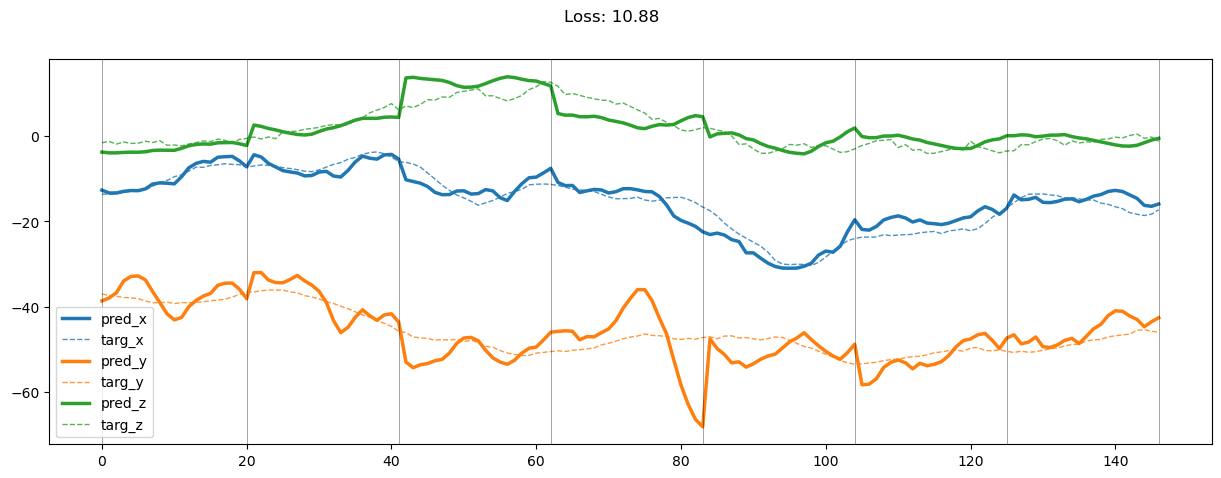

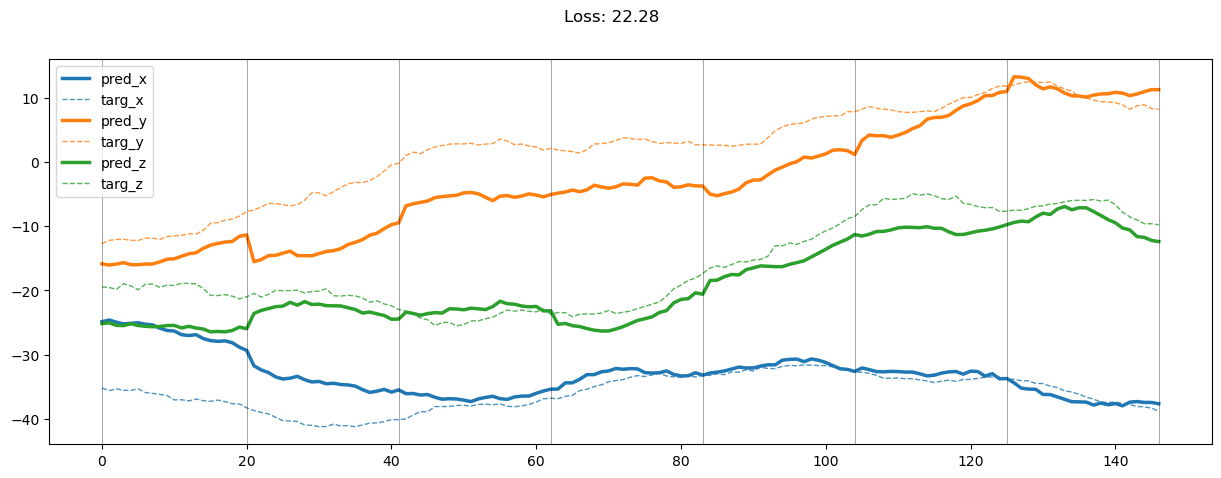

00199: train loss:  13.154, imu loss:  0.662, mag loss:  12.492, div loss:  24.917
       valid loss:  271.952, imu loss:  0.482, mag loss:  271.470, div loss:  255.738
00219: train loss:  13.069, imu loss:  0.661, mag loss:  12.408, div loss:  24.744
       valid loss:  271.811, imu loss:  0.482, mag loss:  271.330, div loss:  256.587
00239: train loss:  13.040, imu loss:  0.660, mag loss:  12.380, div loss:  24.646
       valid loss:  273.249, imu loss:  0.482, mag loss:  272.768, div loss:  256.128
00259: train loss:  12.981, imu loss:  0.660, mag loss:  12.321, div loss:  24.557
       valid loss:  275.070, imu loss:  0.483, mag loss:  274.587, div loss:  256.781
00279: train loss:  12.939, imu loss:  0.659, mag loss:  12.280, div loss:  24.472
       valid loss:  269.766, imu loss:  0.483, mag loss:  269.283, div loss:  252.675
00299: train loss:  12.898, imu loss:  0.658, mag loss:  12.239, div loss:  24.338
       valid loss:  273.183, imu loss:  0.484, mag loss:  272.699, div l

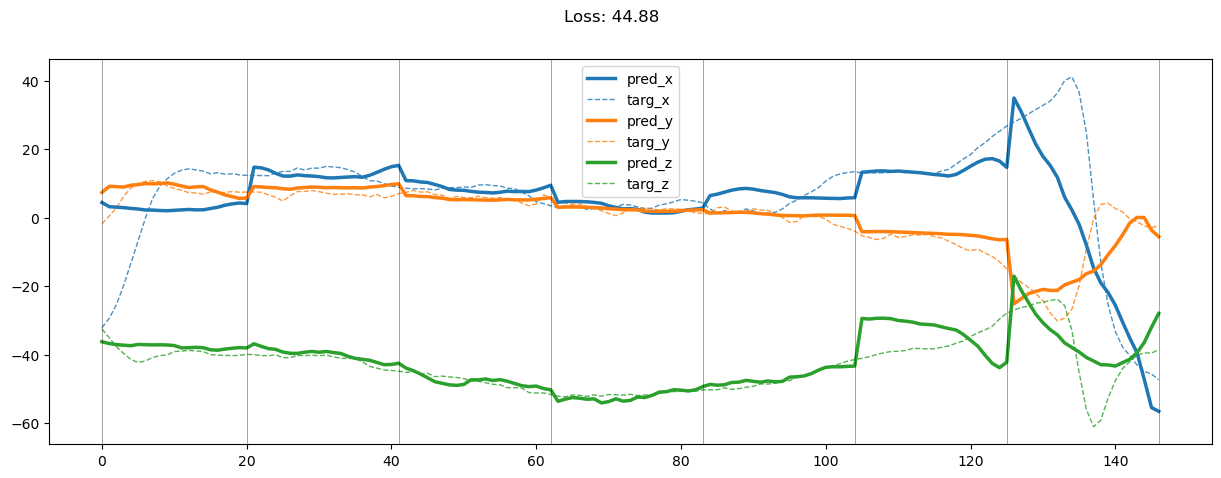

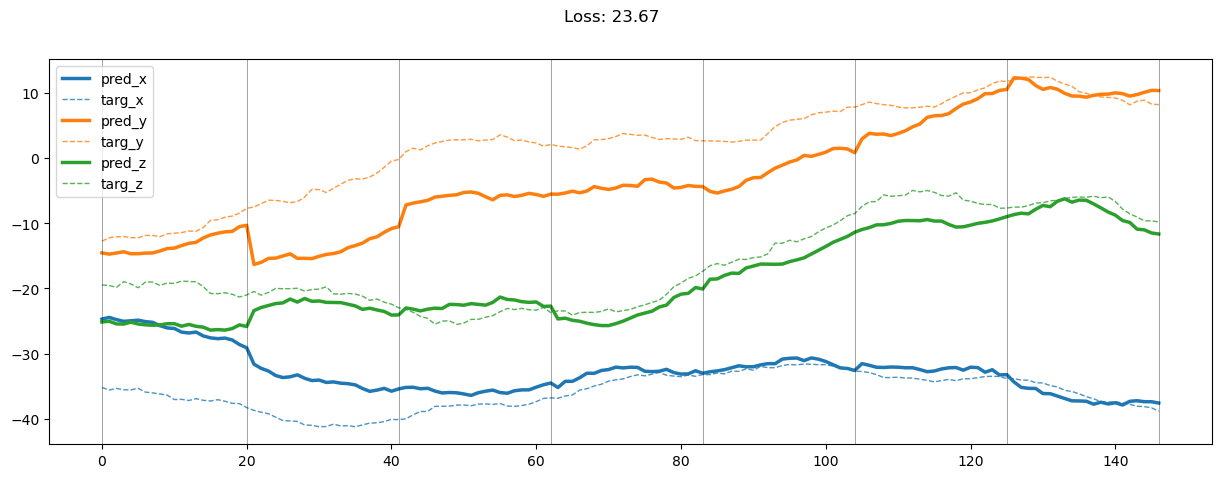

00399: train loss:  12.631, imu loss:  0.654, mag loss:  11.977, div loss:  23.827
       valid loss:  274.023, imu loss:  0.484, mag loss:  273.539, div loss:  260.017
00419: train loss:  12.621, imu loss:  0.653, mag loss:  11.968, div loss:  23.880
       valid loss:  276.545, imu loss:  0.488, mag loss:  276.057, div loss:  259.118
00439: train loss:  12.577, imu loss:  0.652, mag loss:  11.925, div loss:  23.851
       valid loss:  272.940, imu loss:  0.485, mag loss:  272.455, div loss:  257.130
00459: train loss:  12.488, imu loss:  0.651, mag loss:  11.837, div loss:  23.651
       valid loss:  278.221, imu loss:  0.487, mag loss:  277.734, div loss:  263.964
00479: train loss:  12.493, imu loss:  0.651, mag loss:  11.842, div loss:  23.663
       valid loss:  275.995, imu loss:  0.490, mag loss:  275.504, div loss:  259.938
00499: train loss:  12.417, imu loss:  0.650, mag loss:  11.767, div loss:  23.497
       valid loss:  278.755, imu loss:  0.491, mag loss:  278.264, div l

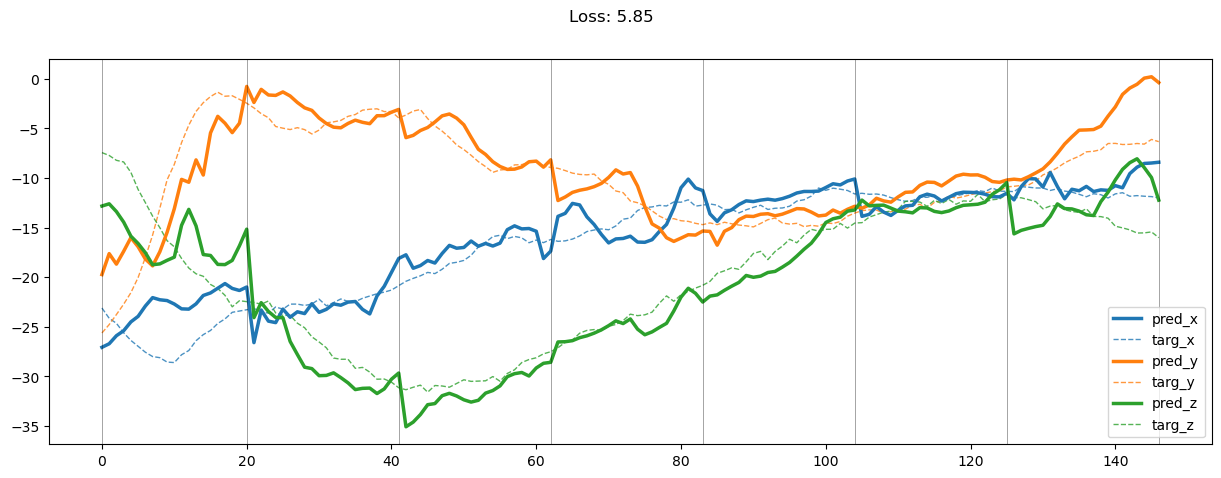

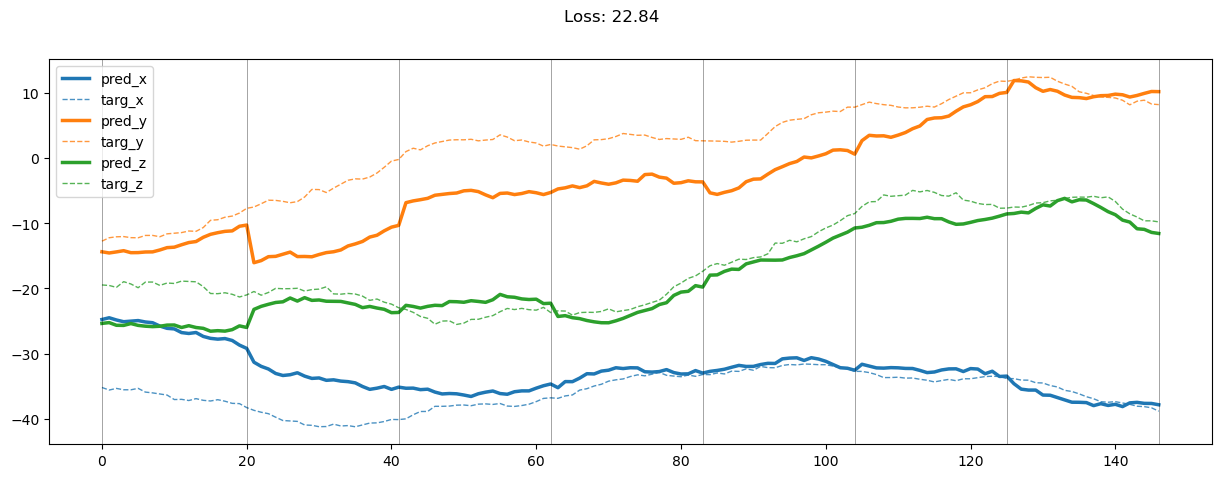

00599: train loss:  12.205, imu loss:  0.645, mag loss:  11.560, div loss:  23.051
       valid loss:  277.817, imu loss:  0.495, mag loss:  277.322, div loss:  260.799
00619: train loss:  12.164, imu loss:  0.645, mag loss:  11.520, div loss:  23.039
       valid loss:  280.318, imu loss:  0.496, mag loss:  279.822, div loss:  265.299
00639: train loss:  12.109, imu loss:  0.643, mag loss:  11.465, div loss:  22.858
       valid loss:  277.203, imu loss:  0.493, mag loss:  276.710, div loss:  261.442
00659: train loss:  12.057, imu loss:  0.642, mag loss:  11.414, div loss:  22.801
       valid loss:  279.529, imu loss:  0.494, mag loss:  279.035, div loss:  262.522
00679: train loss:  12.023, imu loss:  0.642, mag loss:  11.381, div loss:  22.757
       valid loss:  276.403, imu loss:  0.492, mag loss:  275.911, div loss:  260.044
00699: train loss:  12.020, imu loss:  0.641, mag loss:  11.379, div loss:  22.670
       valid loss:  277.287, imu loss:  0.496, mag loss:  276.791, div l

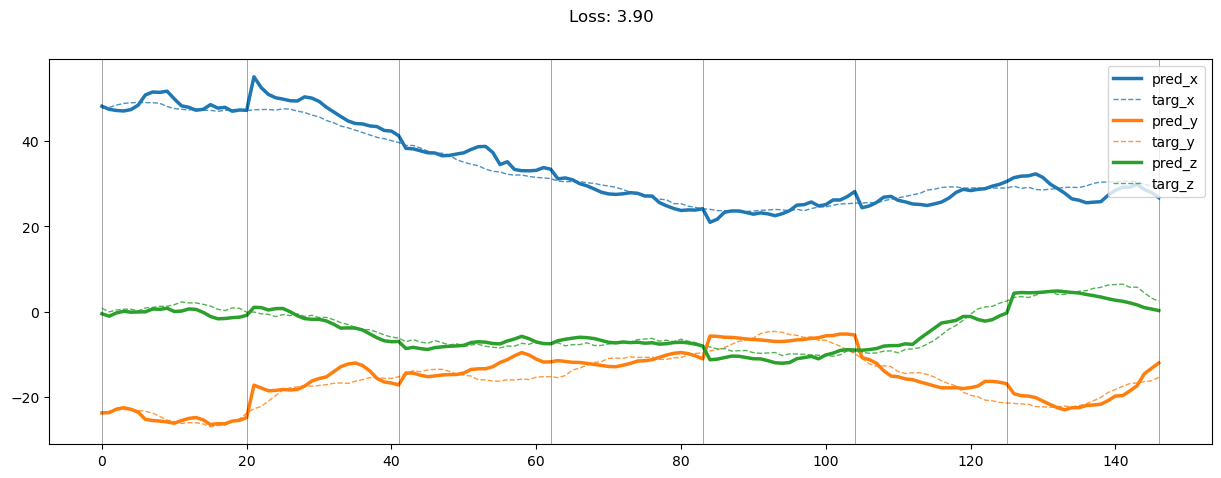

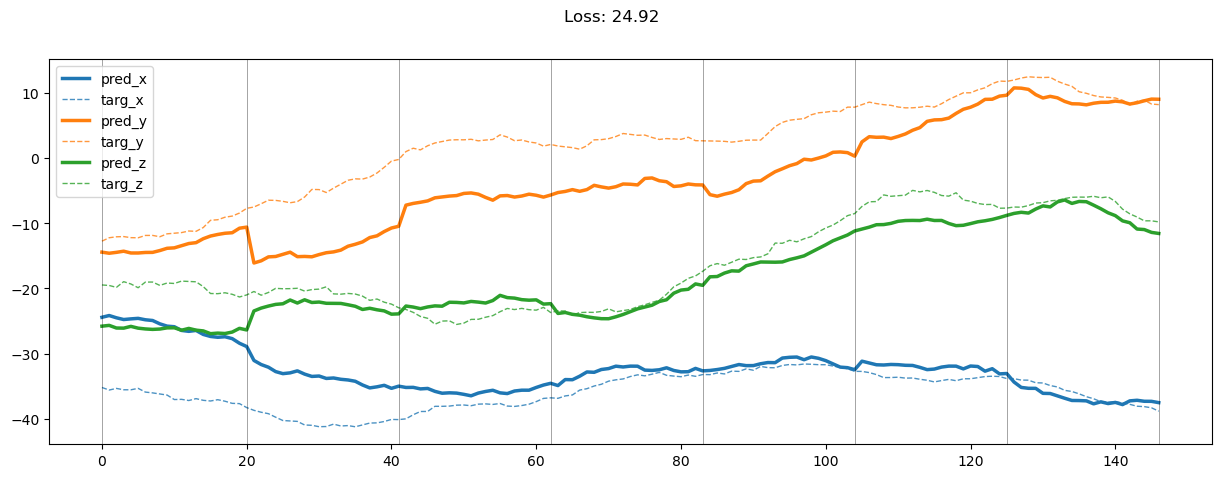

00799: train loss:  11.827, imu loss:  0.636, mag loss:  11.191, div loss:  22.351
       valid loss:  277.705, imu loss:  0.499, mag loss:  277.206, div loss:  259.096
00819: train loss:  11.785, imu loss:  0.635, mag loss:  11.150, div loss:  22.227
       valid loss:  277.092, imu loss:  0.501, mag loss:  276.591, div loss:  259.471
00839: train loss:  11.762, imu loss:  0.634, mag loss:  11.127, div loss:  22.163
       valid loss:  279.265, imu loss:  0.498, mag loss:  278.767, div loss:  262.105
00859: train loss:  11.688, imu loss:  0.632, mag loss:  11.057, div loss:  22.069
       valid loss:  281.721, imu loss:  0.498, mag loss:  281.223, div loss:  262.630
00879: train loss:  11.668, imu loss:  0.631, mag loss:  11.037, div loss:  22.008
       valid loss:  282.760, imu loss:  0.499, mag loss:  282.261, div loss:  263.941
00899: train loss:  11.632, imu loss:  0.631, mag loss:  11.001, div loss:  21.991
       valid loss:  280.100, imu loss:  0.501, mag loss:  279.599, div l

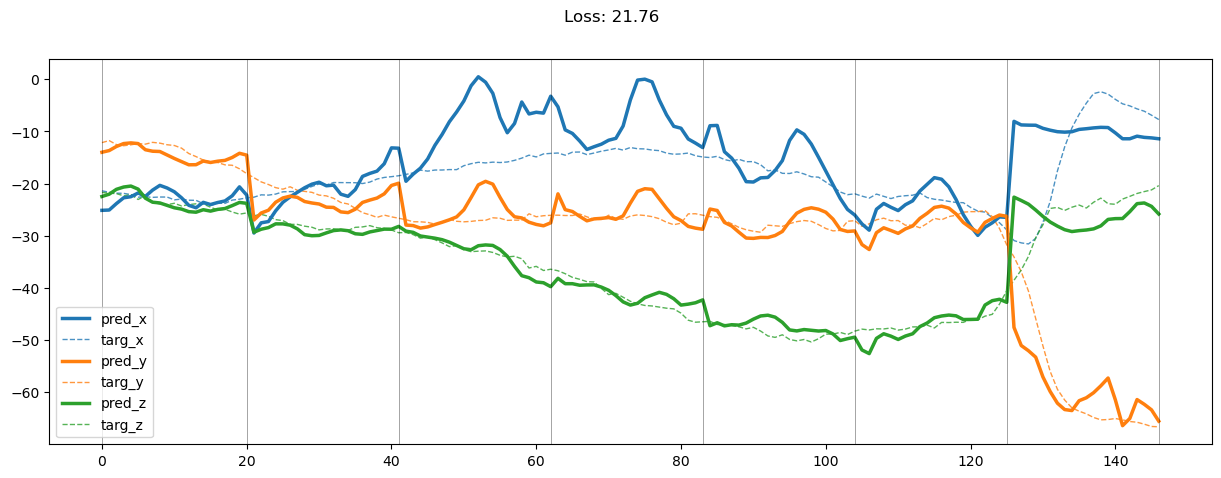

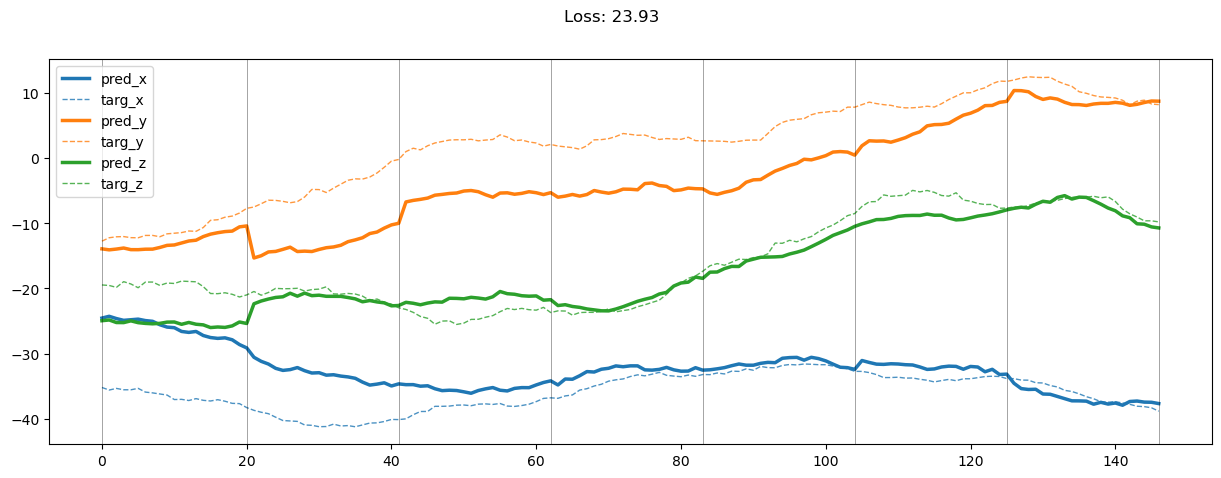

00999: train loss:  11.456, imu loss:  0.625, mag loss:  10.832, div loss:  21.611
       valid loss:  277.643, imu loss:  0.505, mag loss:  277.138, div loss:  262.041
01019: train loss:  11.421, imu loss:  0.623, mag loss:  10.798, div loss:  21.556
       valid loss:  280.909, imu loss:  0.502, mag loss:  280.407, div loss:  262.139
01039: train loss:  11.412, imu loss:  0.622, mag loss:  10.790, div loss:  21.527
       valid loss:  279.776, imu loss:  0.505, mag loss:  279.270, div loss:  259.697
01059: train loss:  11.364, imu loss:  0.621, mag loss:  10.742, div loss:  21.444
       valid loss:  281.539, imu loss:  0.506, mag loss:  281.033, div loss:  265.015
01079: train loss:  11.325, imu loss:  0.619, mag loss:  10.706, div loss:  21.410
       valid loss:  278.288, imu loss:  0.504, mag loss:  277.784, div loss:  265.464
01099: train loss:  11.315, imu loss:  0.618, mag loss:  10.696, div loss:  21.285
       valid loss:  278.325, imu loss:  0.505, mag loss:  277.820, div l

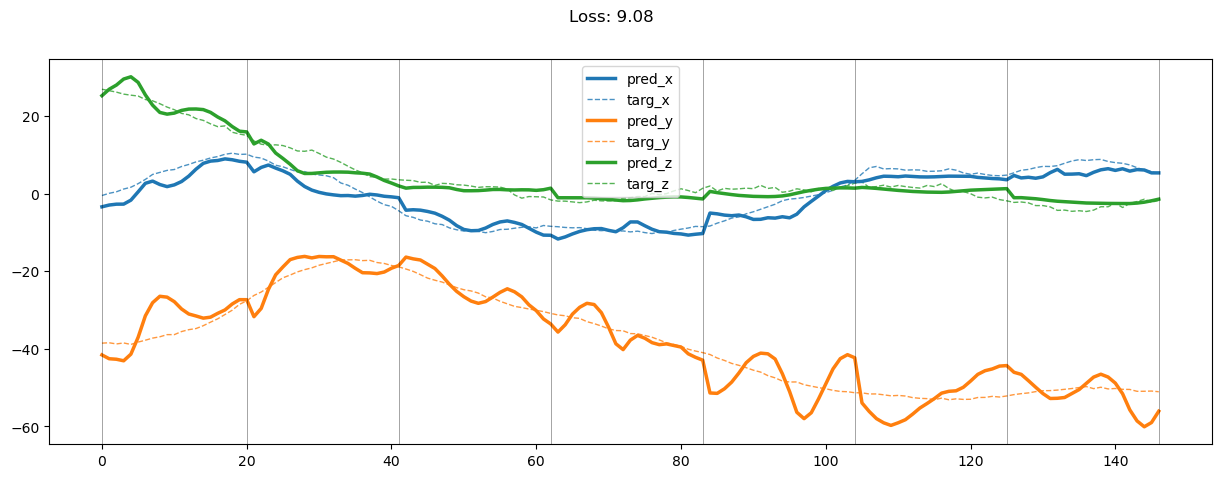

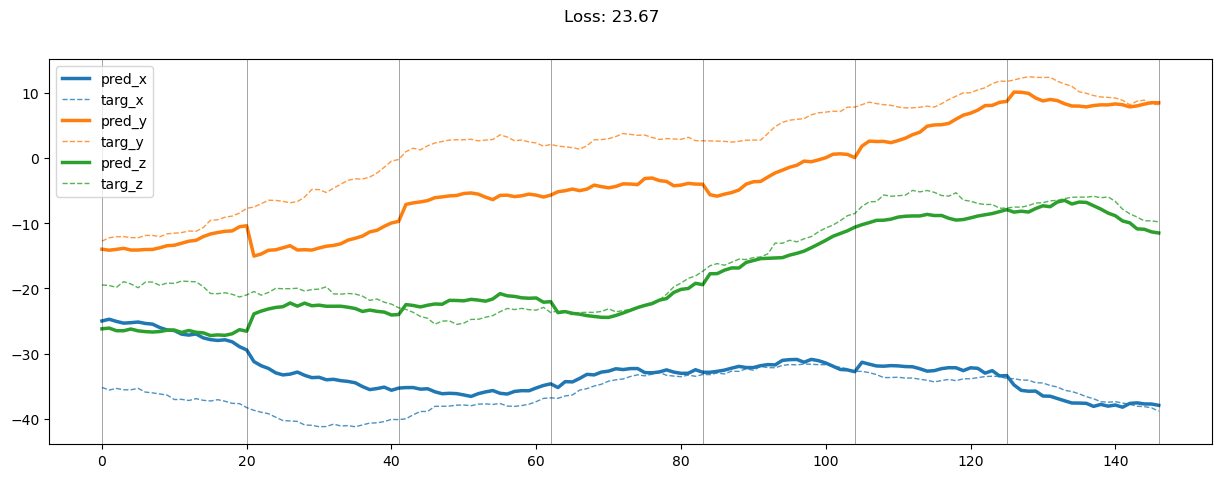

01199: train loss:  11.190, imu loss:  0.613, mag loss:  10.577, div loss:  21.090
       valid loss:  280.042, imu loss:  0.507, mag loss:  279.535, div loss:  267.540
01219: train loss:  11.087, imu loss:  0.611, mag loss:  10.477, div loss:  20.952
       valid loss:  282.769, imu loss:  0.512, mag loss:  282.258, div loss:  269.043
01239: train loss:  11.099, imu loss:  0.609, mag loss:  10.490, div loss:  20.967
       valid loss:  285.013, imu loss:  0.515, mag loss:  284.498, div loss:  272.001
01259: train loss:  11.060, imu loss:  0.608, mag loss:  10.451, div loss:  20.860
       valid loss:  281.651, imu loss:  0.513, mag loss:  281.138, div loss:  266.850
01279: train loss:  11.000, imu loss:  0.608, mag loss:  10.392, div loss:  20.767
       valid loss:  274.938, imu loss:  0.510, mag loss:  274.428, div loss:  259.899
01299: train loss:  10.977, imu loss:  0.606, mag loss:  10.371, div loss:  20.694
       valid loss:  286.483, imu loss:  0.515, mag loss:  285.969, div l

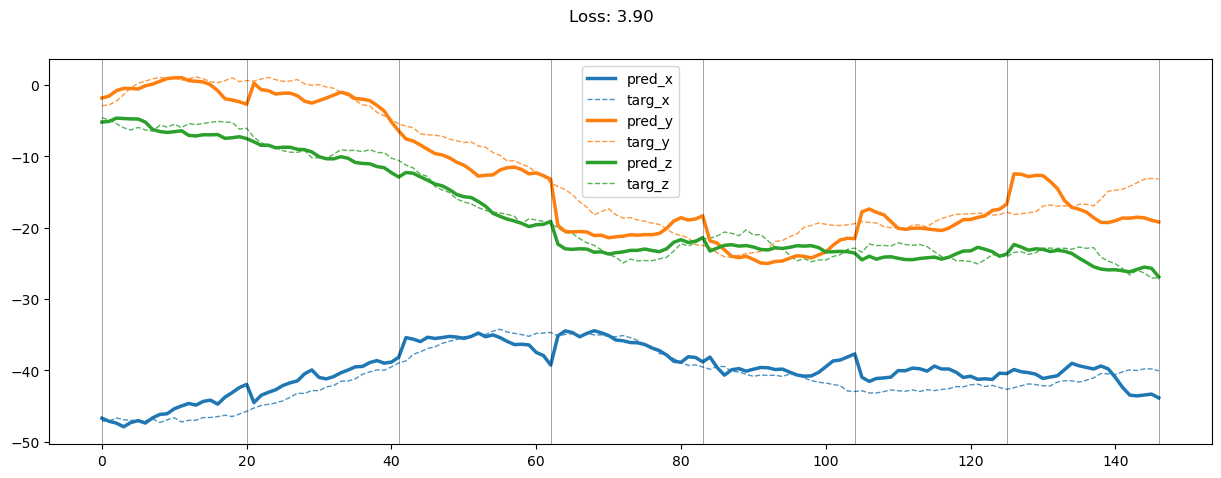

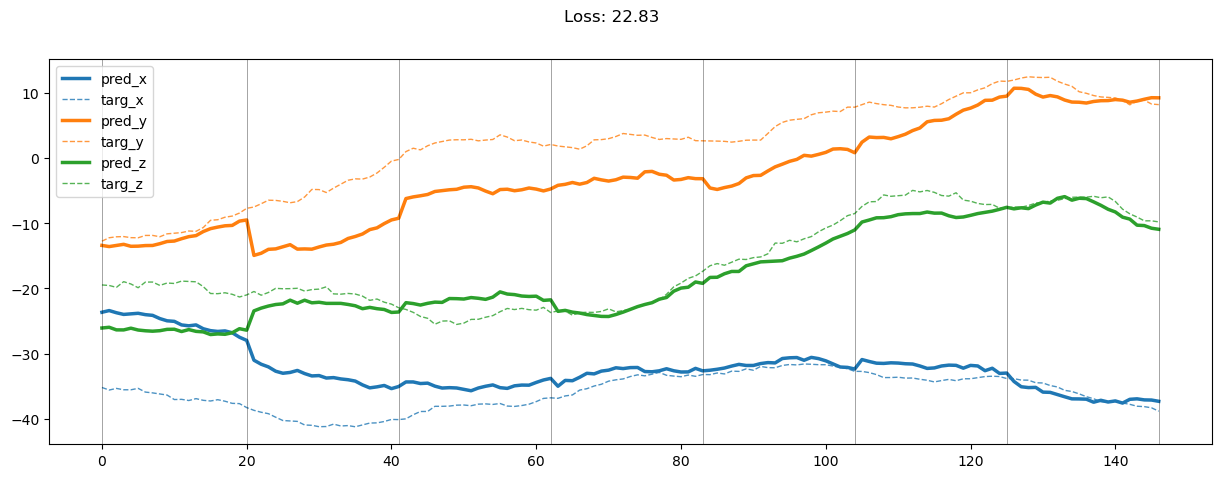

01399: train loss:  10.803, imu loss:  0.599, mag loss:  10.204, div loss:  20.346
       valid loss:  282.801, imu loss:  0.514, mag loss:  282.287, div loss:  265.405
01419: train loss:  10.838, imu loss:  0.597, mag loss:  10.241, div loss:  20.442
       valid loss:  285.895, imu loss:  0.516, mag loss:  285.379, div loss:  272.941
01439: train loss:  10.763, imu loss:  0.596, mag loss:  10.167, div loss:  20.306
       valid loss:  279.891, imu loss:  0.520, mag loss:  279.371, div loss:  265.717
01459: train loss:  10.700, imu loss:  0.595, mag loss:  10.105, div loss:  20.223
       valid loss:  281.775, imu loss:  0.517, mag loss:  281.258, div loss:  262.737
01479: train loss:  10.670, imu loss:  0.593, mag loss:  10.077, div loss:  20.099
       valid loss:  281.171, imu loss:  0.521, mag loss:  280.650, div loss:  264.678
01499: train loss:  10.637, imu loss:  0.590, mag loss:  10.047, div loss:  20.008
       valid loss:  281.260, imu loss:  0.517, mag loss:  280.743, div l

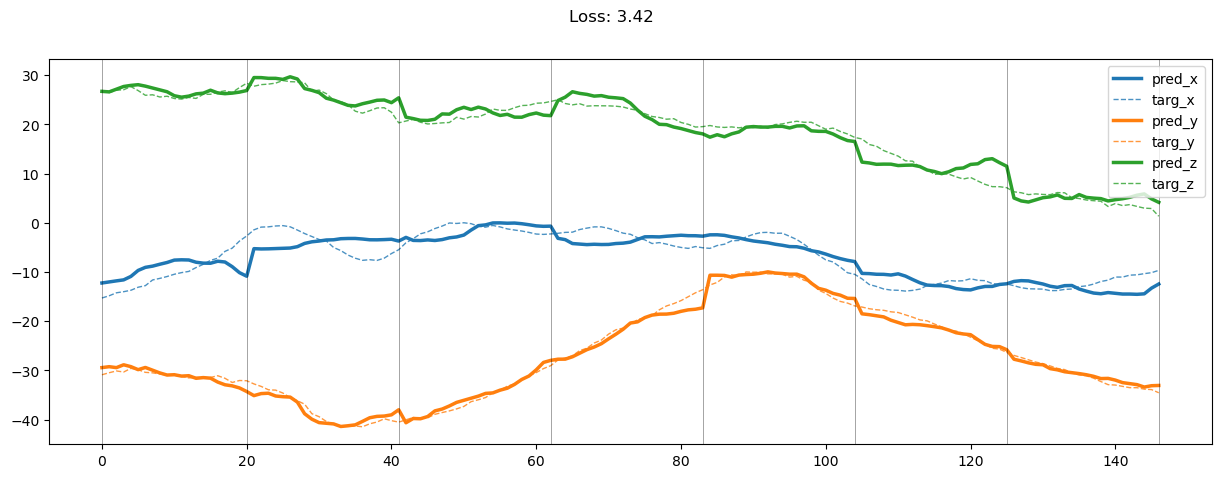

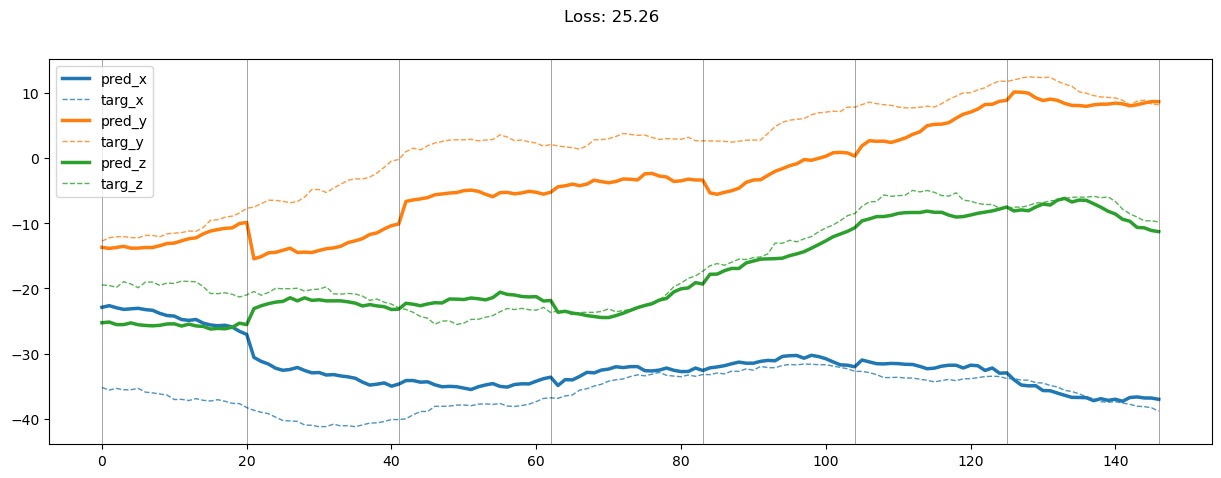

01599: train loss:  10.444, imu loss:  0.583, mag loss:  9.861, div loss:  19.697
       valid loss:  284.529, imu loss:  0.522, mag loss:  284.007, div loss:  267.226
01619: train loss:  10.466, imu loss:  0.581, mag loss:  9.885, div loss:  19.653
       valid loss:  283.523, imu loss:  0.524, mag loss:  282.998, div loss:  267.114
01639: train loss:  10.384, imu loss:  0.579, mag loss:  9.804, div loss:  19.526
       valid loss:  286.255, imu loss:  0.525, mag loss:  285.729, div loss:  266.419
01659: train loss:  10.369, imu loss:  0.578, mag loss:  9.791, div loss:  19.564
       valid loss:  283.701, imu loss:  0.529, mag loss:  283.171, div loss:  263.935
01679: train loss:  10.313, imu loss:  0.576, mag loss:  9.737, div loss:  19.483
       valid loss:  284.283, imu loss:  0.529, mag loss:  283.754, div loss:  262.292
01699: train loss:  10.310, imu loss:  0.574, mag loss:  9.735, div loss:  19.420
       valid loss:  286.452, imu loss:  0.525, mag loss:  285.928, div loss:  

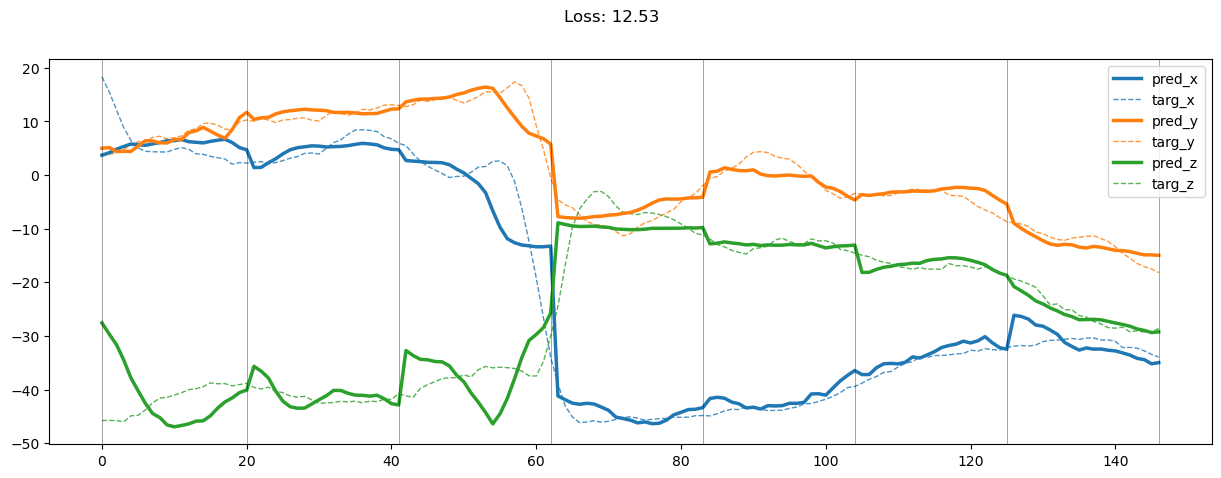

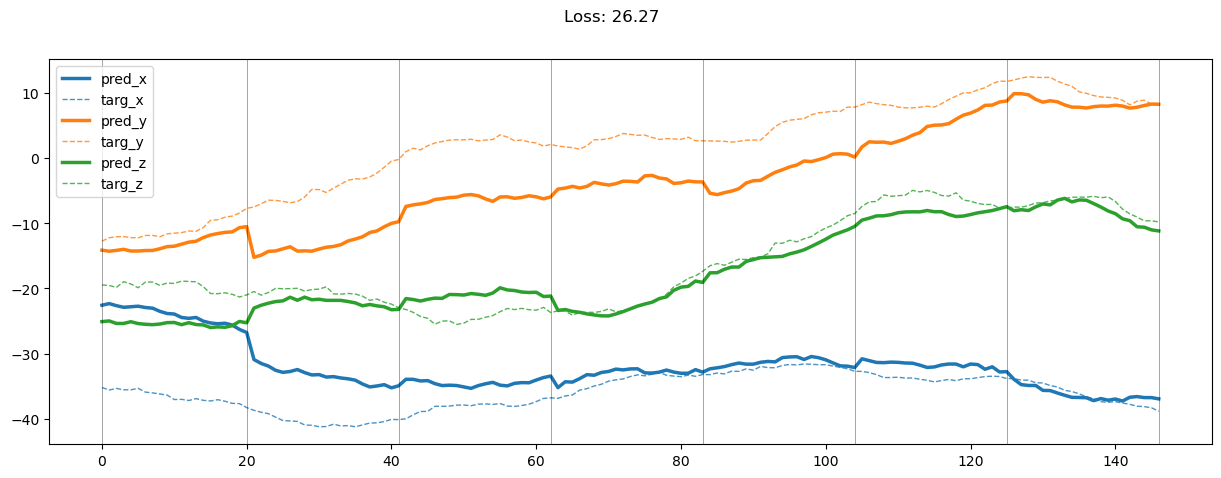

01799: train loss:  10.176, imu loss:  0.564, mag loss:  9.611, div loss:  19.162
       valid loss:  286.074, imu loss:  0.529, mag loss:  285.545, div loss:  267.725
01819: train loss:  10.119, imu loss:  0.563, mag loss:  9.557, div loss:  19.146
       valid loss:  286.368, imu loss:  0.531, mag loss:  285.836, div loss:  266.289
01839: train loss:  10.092, imu loss:  0.560, mag loss:  9.532, div loss:  19.028
       valid loss:  285.394, imu loss:  0.526, mag loss:  284.868, div loss:  263.749
01859: train loss:  10.047, imu loss:  0.557, mag loss:  9.490, div loss:  18.978
       valid loss:  286.120, imu loss:  0.531, mag loss:  285.589, div loss:  264.751
01879: train loss:  10.151, imu loss:  0.556, mag loss:  9.595, div loss:  19.118
       valid loss:  282.135, imu loss:  0.538, mag loss:  281.597, div loss:  263.649
01899: train loss:  10.004, imu loss:  0.553, mag loss:  9.451, div loss:  18.865
       valid loss:  279.169, imu loss:  0.530, mag loss:  278.638, div loss:  

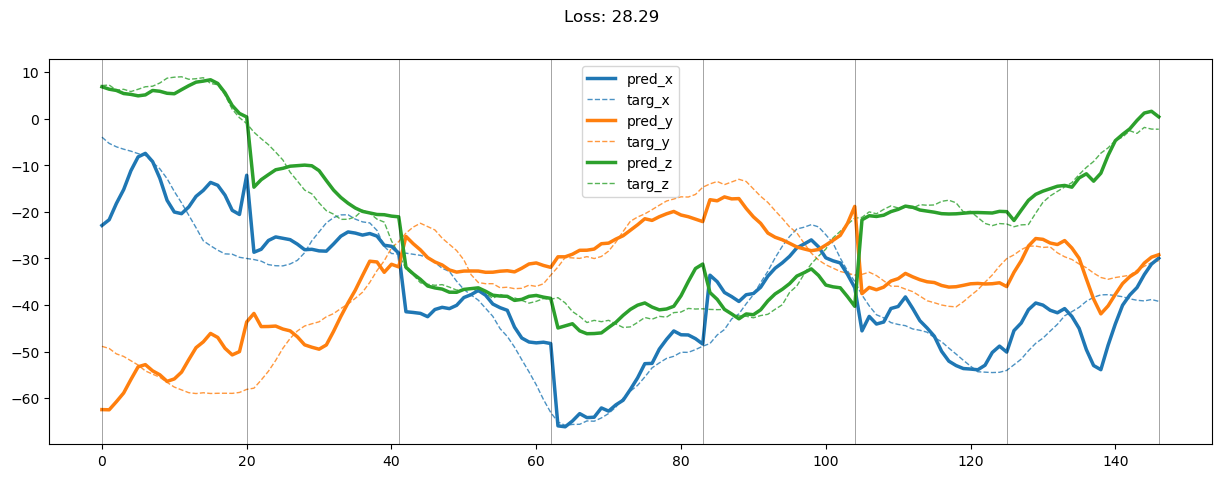

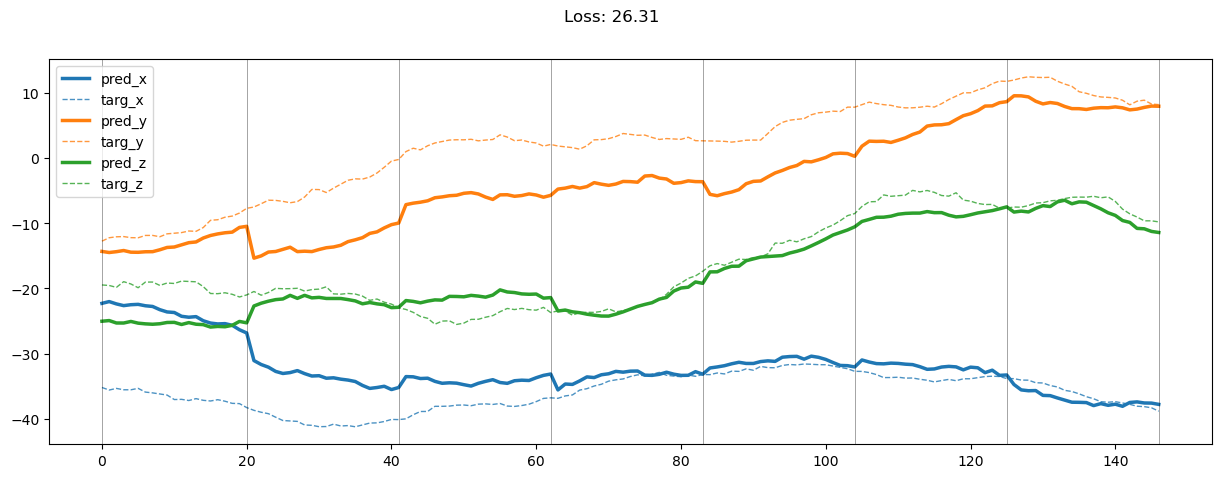

01999: train loss:  9.879, imu loss:  0.541, mag loss:  9.338, div loss:  18.580
       valid loss:  290.593, imu loss:  0.533, mag loss:  290.060, div loss:  269.624


In [49]:
draw = False

for epoch in range(EPOCH):
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}')

In [50]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]
            
            class_result = classifier.predict_label(source_imu)

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag, class_result)
            

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [51]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(5500, 3) (5500,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    11.15     6.51     7.25     8.30
         pocket loss:     9.54     8.48     6.19     8.07
          swing loss:    11.41    14.82    13.22    13.15
        average loss:    10.69     9.86     8.83     9.79


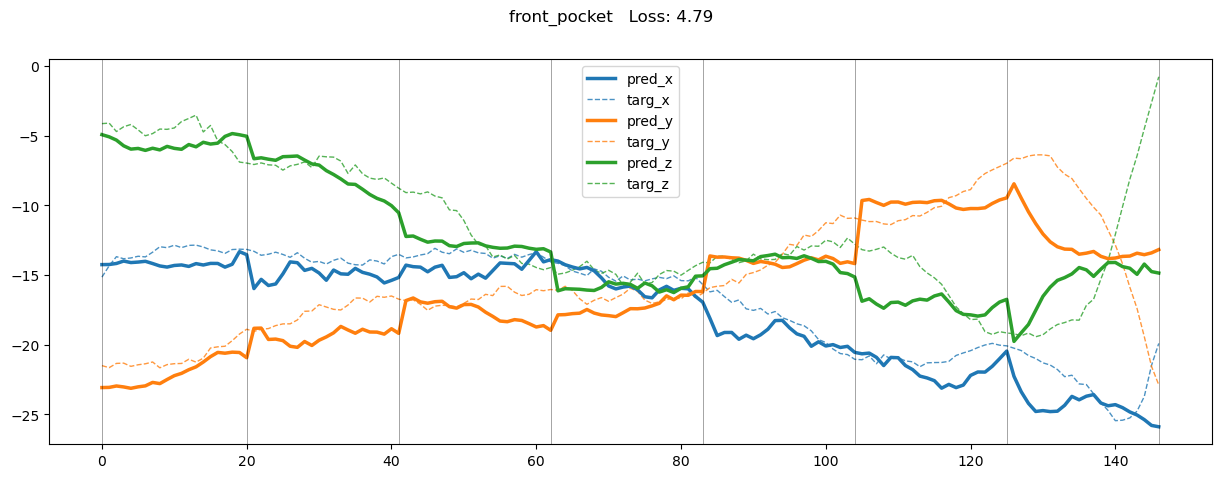

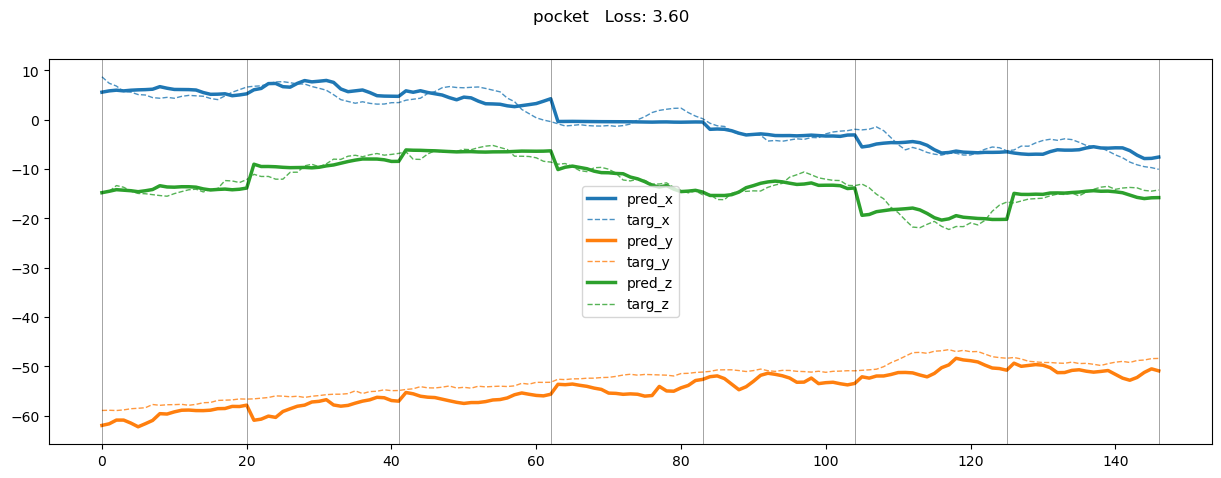

In [52]:
results, cres, clabel = output_eval(model, train_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::5000]:
    plot_result(rs)

(205, 3) (205,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    70.00   183.17    91.77   114.98
         pocket loss:   462.47   444.78   340.71   415.99
          swing loss:   208.56   411.28   471.92   363.92
        average loss:   236.57   339.24   294.37   290.06


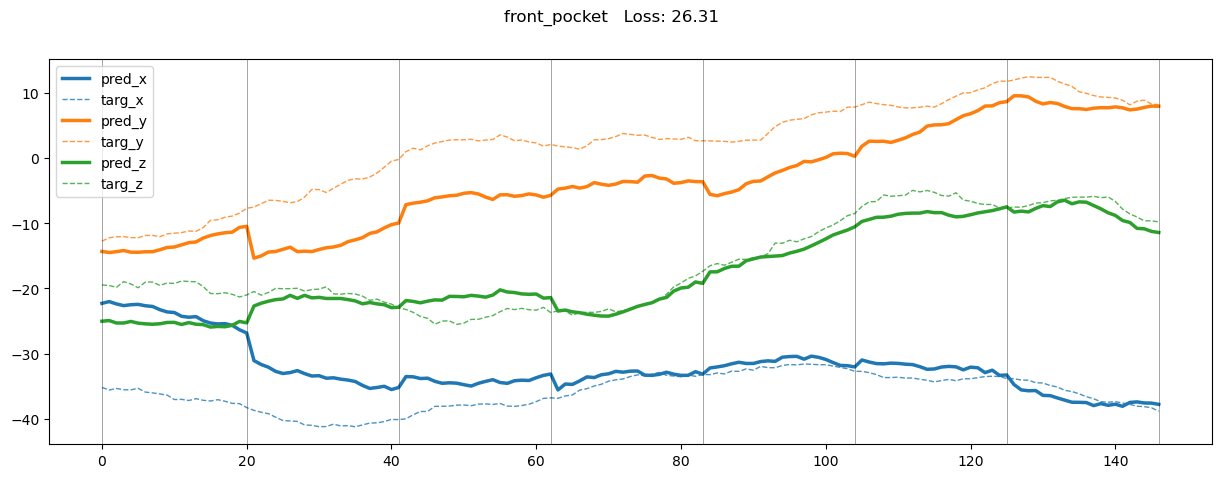

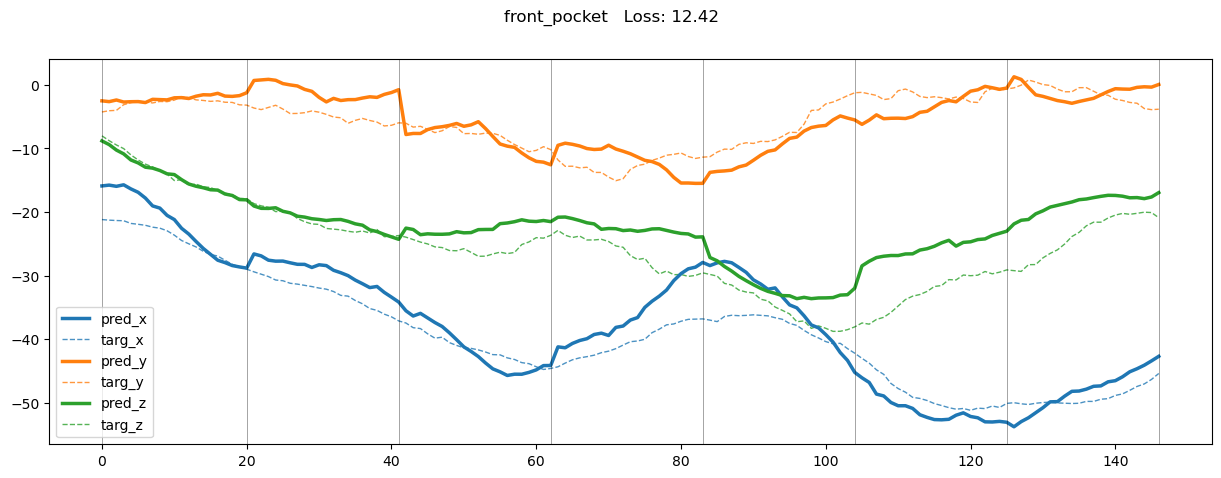

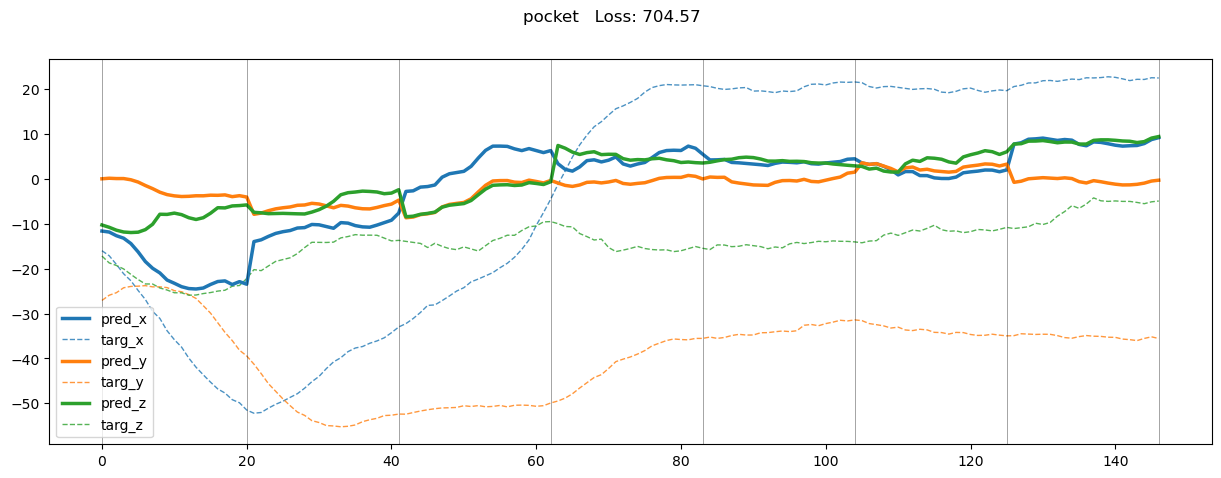

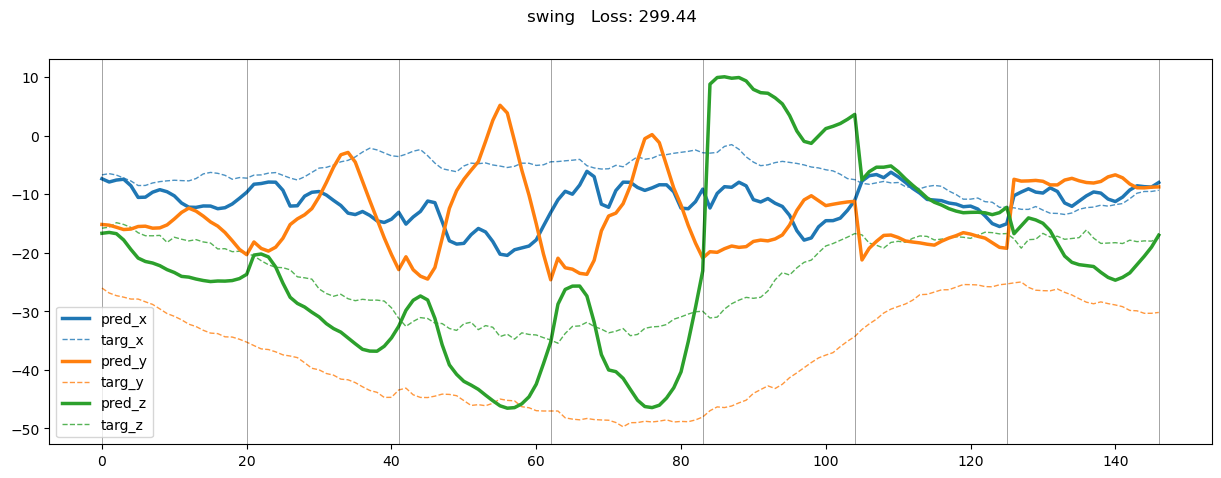

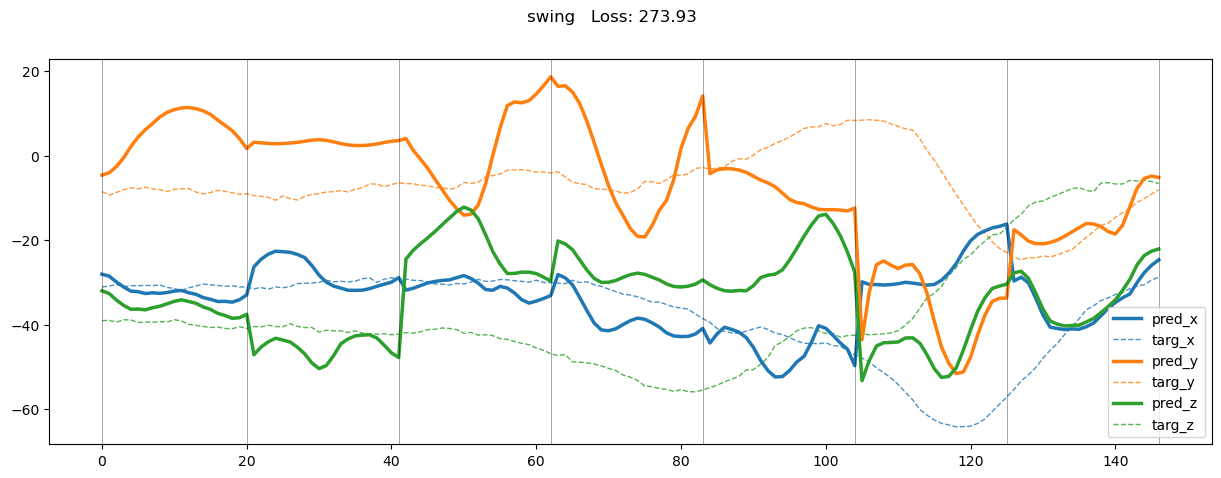

In [53]:
results, cres, clabel = output_eval(model, valid_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::50]:
    plot_result(rs)